In [1]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)

batch_size = 64  
epochs = 100  
latent_dim = 256
df = pd.read_csv('deu.txt',delimiter='\t',header = None).iloc[:,:2]
df.columns = ['eng','deu']
df

,eng,deu
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!
...,...,...
248306,If someone who doesn't know your background sa...,"Wenn jemand Fremdes dir sagt, dass du dich wie..."
248307,If someone who doesn't know your background sa...,"Wenn jemand, der nicht weiß, woher man kommt, ..."
248308,It may be impossible to get a completely error...,"Es ist wohl unmöglich, einen vollkommen fehler..."
248309,I know that adding sentences only in your nati...,"Ich weiß wohl, dass das ausschließliche Beitra..."


Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 83
Max sequence length for inputs: 15
Max sequence length for outputs: 51
Epoch 1/20
118/118 [==============================] - 12s 78ms/step - loss: 1.1260 - val_loss: 1.2929
Epoch 2/20
118/118 [==============================] - 9s 72ms/step - loss: 1.0249 - val_loss: 1.1919
Epoch 3/20
118/118 [==============================] - 9s 78ms/step - loss: 0.9641 - val_loss: 1.1493
Epoch 4/20
118/118 [==============================] - 9s 76ms/step - loss: 0.9255 - val_loss: 1.0490
Epoch 5/20
118/118 [==============================] - 9s 75ms/step - loss: 0.8890 - val_loss: 1.0374
Epoch 6/20
118/118 [==============================] - 9s 75ms/step - loss: 0.8575 - val_loss: 0.9963
Epoch 7/20
118/118 [==============================] - 9s 76ms/step - loss: 0.8280 - val_loss: 0.9882
Epoch 8/20
118/118 [==============================] - 9s 77ms/step - loss: 0.8000 - val_loss: 1.0174
Epoch 9/20
118/118 [======

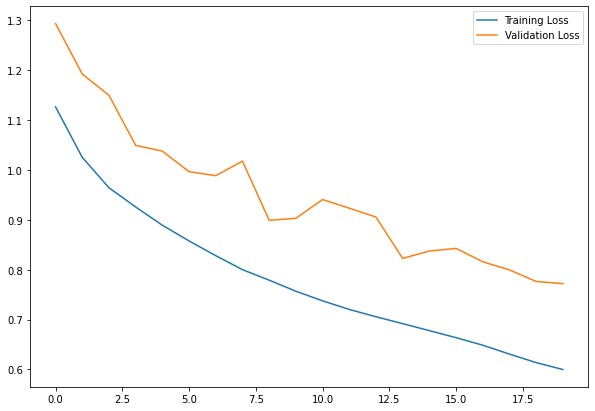

'Fast dich dich.\n'

In [2]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for line in df.iloc[:10000].iterrows():
    input_text = line[1]['eng']
    target_text = line[1]['deu']
    
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
print('Number of samples:', len(input_texts))

input_characters = sorted(list(input_characters)) 
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) 
num_decoder_tokens = len(target_characters)
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}
max_encoder_seq_length = max([len(txt) for txt in input_texts]) 
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
encoder_inputs = Input(shape=(None, num_encoder_tokens), name = 'encoder_inputs')
encoder = CuDNNLSTM(latent_dim,return_state=True, name = 'encoder')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape=(None, num_decoder_tokens), name = 'decoder_inputs')
decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True,name = 'decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens,activation='softmax', name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=20,validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
reverse_input_char_index = {i: char for char, i in input_token_index.items()}
reverse_target_char_index = {i: char for char, i in target_token_index.items()}
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

my_text = 'I am here'
placeholder = np.zeros((1,len(my_text)+10,num_encoder_tokens))
decode_sequence(placeholder)

Random Seed:  8788
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:34:17<00:00, 226.30s/it]


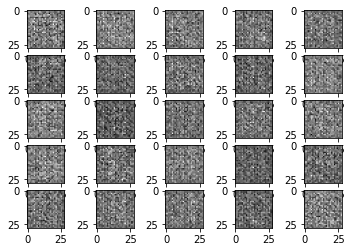

In [1]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

cudnn.benchmark = True
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
dataset = dset.MNIST(root='test1', download=True,transform=transforms.Compose([transforms.Resize(28),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]))
nc=1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,shuffle=True, num_workers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ngpu = 1
nz = 100
ngf = 64
ndf = 64

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0
niter = 25
import tqdm
for epoch in tqdm.tqdm(range(niter)):
    for i, data in enumerate(dataloader, 0):
        if i>500:
          break
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device).to(torch.float32)
        output = netD(real_cpu).to(torch.float32)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 100 == 0:
            fake = netG(fixed_noise)

num_gpu = 1 if torch.cuda.is_available() else 0
D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

batch_size = 25
latent_size = 100
fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
plt.show()
